Transformed MNIST
===

Input images
---

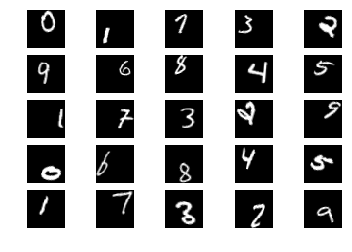

In [16]:
%matplotlib inline
from matplotlib import pyplot

from lib import load_batch
b = load_batch(1)

for row in range(5):
    for col in range(5):
        num = row * 5 + col
        pyplot.subplot(5, 5, num + 1)
        pyplot.axis('off')
        pyplot.imshow(b.image[num], cmap='gray')

Preprocessing
---

The images are cropped and put centraly inside a (34, 34) square.

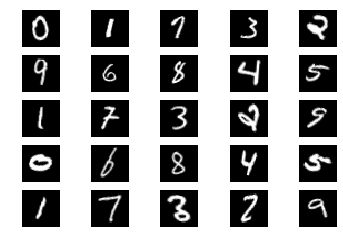

In [23]:
%matplotlib inline
from matplotlib import pyplot

from lib import load_batch, center
b = load_batch(1)

for row in range(5):
    for col in range(5):
        num = row * 5 + col
        pyplot.subplot(5, 5, num + 1)
        pyplot.axis('off')
        pyplot.imshow(center(b.image[num]), cmap='gray')

Model architecture
---

In [30]:
%matplotlib inline
from keras.models import load_model
from keras.utils.visualize_util import plot
model = load_model("my_model.h5")
plot(model)

![title](model.png)

Training and prediction
---

The following steps assume that test.csv and folder training_and_validation_batches with mat files are inside folder data.

**Warning!** The following steps take many hours on a decent hardware and override saved model weights, training history and answers.

In [35]:
!python convnet_centered_deeper.py
!python train.py 1 33 40 center 

Using TensorFlow backend.
Using TensorFlow backend.
^C
Traceback (most recent call last):
  File "train.py", line 5, in <module>
    perform_training(int(sys.argv[1]), int(sys.argv[2]), int(sys.argv[3]), preprocessing_map[sys.argv[4]])
  File "/Users/michal/PycharmProjects/ml1617-mnist/lib.py", line 91, in perform_training
    train_x = preprocessing(train_x)
  File "/Users/michal/PycharmProjects/ml1617-mnist/lib.py", line 175, in array_center
    return apply_by_row(center, array.reshape(-1, 40, 40)).reshape(-1, 34, 34, 1)
  File "/Users/michal/PycharmProjects/ml1617-mnist/lib.py", line 169, in apply_by_row
    stuff.append(func(row))
KeyboardInterrupt


In [ ]:
!python make_test_npy.py
!python preprocess_test.py
!python answer.py

Training diagrams
---

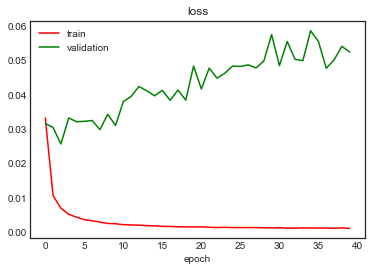

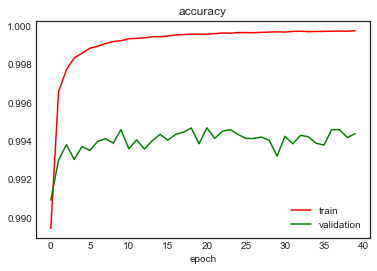

In [31]:
%matplotlib inline


import json
import numpy
from matplotlib import pyplot as plt
with open("my_hist.json") as f:
    hist = json.load(f)
plt.style.use('seaborn-white')
    
axis = numpy.arange(0, len(hist['val_categorical_accuracy']), 1)

plt.figure(1)
plt.title("loss")
plt.plot(axis, hist['loss'], 'r', label='train')
plt.plot(axis, hist['val_loss'], 'g', label='validation')
plt.xlabel("epoch")
plt.legend()


plt.figure(2)
plt.title("accuracy")
plt.plot(axis, hist['categorical_accuracy'], 'r', label='train')
plt.plot(axis, hist['val_categorical_accuracy'], 'g', label='validation')
plt.xlabel("epoch")
plt.legend()

In [32]:
with open("my_hist.json") as f:
    hist = json.load(f)


print("Final validation loss:", hist["val_loss"][-1])
print("Final validation accuracy", hist["val_categorical_accuracy"][-1])

Final validation loss: 0.05241838545081129
Final validation accuracy 0.994390625


Visualizing layers
---

In [78]:
from keras.models import load_model
model = load_model("my_model.h5")

In [79]:
from keras.models import Sequential

In [80]:
new_model = Sequential()
for l in model.flattened_layers[:10]:
    new_model.add(l)
new_model.compile(loss='categorical_crossentropy', optimizer='sgd')

In [86]:
out = new_model.predict(image[0:100])


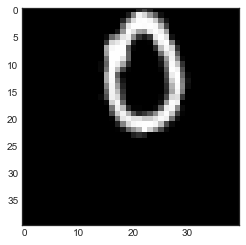

In [87]:
plt.imshow(image[0, :, :, 0], cmap='gray')


(100, 5, 5, 32)


/Users/michal/.virtualenvs/ml1617/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


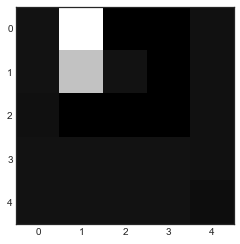

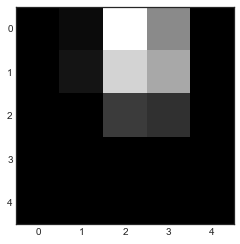

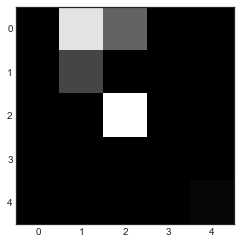

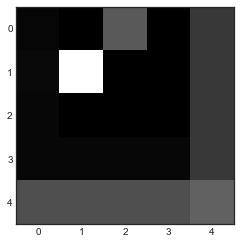

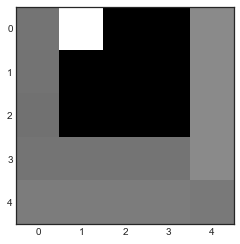

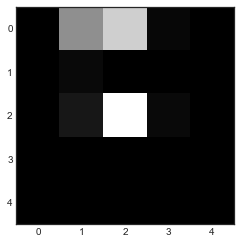

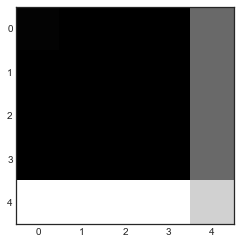

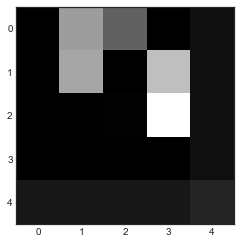

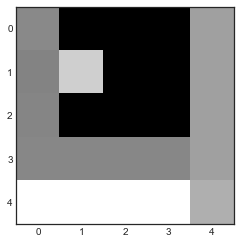

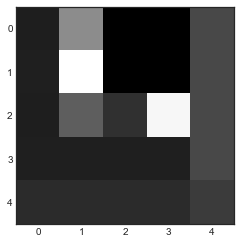

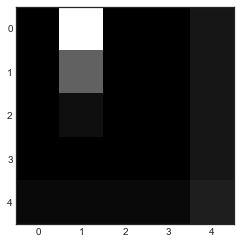

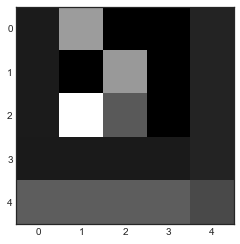

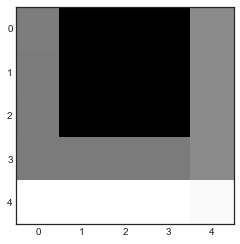

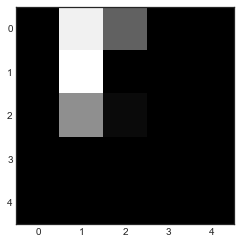

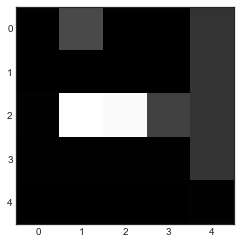

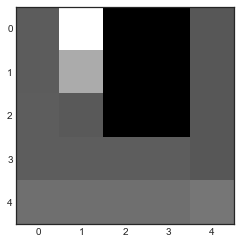

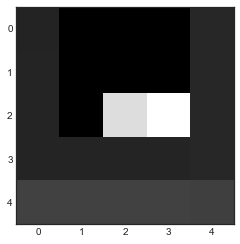

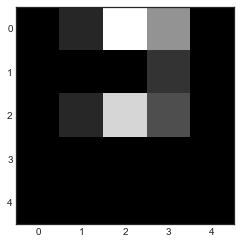

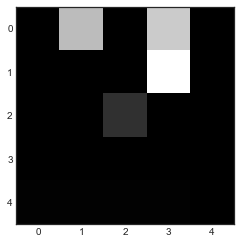

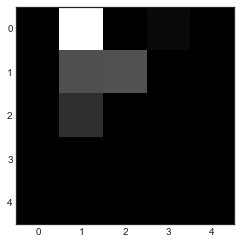

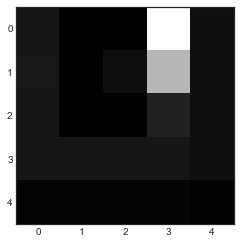

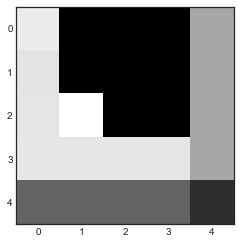

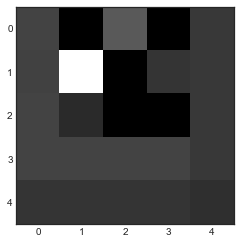

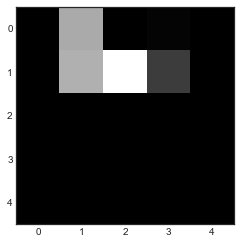

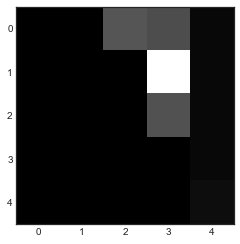

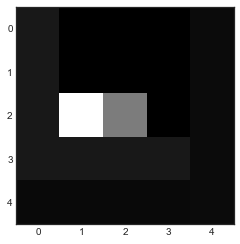

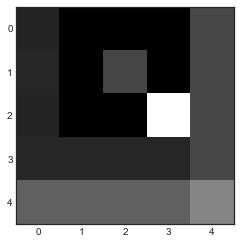

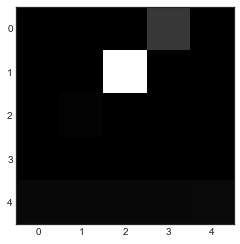

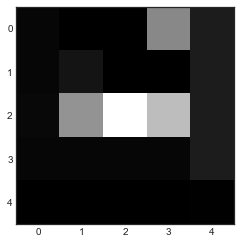

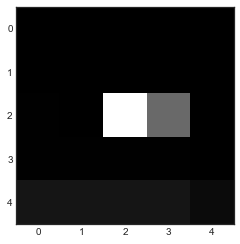

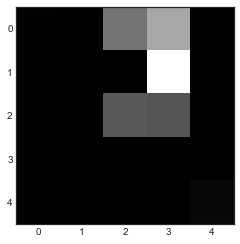

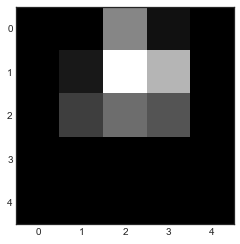

In [85]:
print(out.shape)
for t in range(0, out.shape[3]):
    plt.figure()
    plt.imshow(out[0, :, :, t], cmap='gray')

Why 34x34?
---

All images fit 34x34.

In [2]:
import numpy
from lib import getbbox, load_batch

def batch_height_width(num):
    b = load_batch(num)
    for image in b.image:
        bbox = getbbox(image)
        height, width = bbox[1] - bbox[0], bbox[3] - bbox[2]
        yield height, width

def get_batches_height_width():
    for batch_num in range(1, 33):
        b = numpy.array(list(batch_height_width(batch_num)))
        yield b
        
b = numpy.array(list(get_batches_height_width()))
b.max(axis=0).max(axis=0)

array([34, 32])

In [27]:
import pandas
from lib import getbbox
def get_test_sizes():
    for chunk in pandas.read_csv("data/test.csv", chunksize=1000):
        chunk = chunk.values
        for image in chunk:
            assert image.shape == (1601,)
            image = image[1:].reshape(40, 40)
            bbox = getbbox(image)
            height, width = bbox[1] - bbox[0], bbox[3] - bbox[2]
            yield height, width
a = numpy.array(list(get_test_sizes()))
print(a.max(axis=0))

[34 32]
